# LIVRABLE 3 - Captioning

## 1. Imports et Paramètres

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

keras = tf.keras

In [2]:
max_cap_len = 15  # Determines max length of captioning sentences
img_dimension = 299 # Determines the height and width of images
num_words = 10000 # Determines vocab size to tokenize and train on
encoding_size = 512 # Determines dimension of the encodings of images
LSTM_size = 512 
batch_size = 128
n_epochs = 15
Buffer_size = 1000
validation_and_test_split = 0.2
test_to_val_split = 0.5
num_examples = None # Determines number of overall read samples. If set to none all samples will be read as long as they don't exceed max_cap_len

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 2. Chargement du dataset MS COCO


In [4]:
annotation_folder = "/annotations/"
annotation_file = os.path.abspath('.')+"/annotations/captions_train2017.json"

image_folder = '/train2017/'
PATH = os.path.abspath('.') + image_folder

print("chemin fichier annotation : ", annotation_file)
print("chemin dossier images : ", PATH)

chemin fichier annotation :  C:\Users\1732654\Desktop\EXIA\ML/annotations/captions_train2017.json
chemin dossier images :  C:\Users\1732654\Desktop\EXIA\ML/train2017/


## 3. Sélection des images et annotations

In [5]:
annotation_file = os.path.abspath('.')+"/annotations/captions_train2017.json"
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = annot['caption']

    # Selection des annotations répondant aux paramètres
    if len(caption.split(" ")) > max_cap_len:
      continue
    else:
      caption = '<sos> ' + caption + ' <eos>'
      image_id = annot['image_id']
      full_coco_image_path = PATH + '%012d.jpg' % (image_id)

      all_img_name_vector.append(full_coco_image_path)
      all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=42)
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

caption_train, captions_test, img_name_vector_train, img_name_vector_test = train_test_split(train_captions,
                                                                      img_name_vector,
                                                                      test_size= validation_and_test_split)

caption_val, caption_test, img_name_vector_val, img_name_vector_test = train_test_split(captions_test,
                                                        img_name_vector_test,
                                                        test_size= test_to_val_split)
num_samples = len(img_name_vector)
assert len(train_captions) == len(img_name_vector)
print("Loaded %d samples" %(num_samples))
print("Loaded %d train samples" %(len(caption_train)))
print("Loaded %d valid samples" %(len(caption_val)))
print("Loaded %d test samples" %(len(caption_test)))


Loaded 569949 samples
Loaded 455959 train samples
Loaded 56995 valid samples
Loaded 56995 test samples


## 4. Prétraitement des annotations

Au niveau du prétraitement des annotations, nous avons décidé de suivre un schéma d’étapes que nous expliquons ci-dessous :

Tout d’abord, exécuter une division des mots dans les légendes à l’aide des caractères spéciaux (espaces, ponctuations) pour construire un vocabulaire.
Effectuer une numérotation des mots dans le dictionnaire pour former des annotations lisibles pour les algorithmes de traitement de texte.
Remplir les annotations pour qu’elles aient tous la même taille.

In [6]:
tok = keras.preprocessing.text.Tokenizer(num_words = num_words, filters ="!?,'()_-+=&*$#@.",oov_token="<unk>")
tok.fit_on_texts(caption_train)
captions_train = tok.texts_to_sequences(caption_train)
if num_words == None:
  words = len(tok.word_index)
else:
  words = num_words
captions_train = keras.preprocessing.sequence.pad_sequences(captions_train, padding='post',maxlen=max_cap_len + 2)
print("Example : ", captions_train[np.random.randint(low=0, high= len(captions_train) - 1,size=1)[0]])
print("Found %d unique words" %(words))

Example :  [   3    2   34    6 1753   20  106    2   25    8    7   55    4    0
    0    0    0]
Found 10000 unique words


In [7]:
captions_valid = tok.texts_to_sequences(caption_val)
captions_valid = keras.preprocessing.sequence.pad_sequences(captions_valid, padding='post',maxlen=max_cap_len + 2)

## 5. Préparation du dataset

In [8]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (img_dimension, img_dimension))
  return img

In [9]:
def preprocess_func(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_train,indices=path_index)
  img = load_img(path)#/255.0
  #Preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]
  
  h_and_c_init = tf.zeros((LSTM_size))
   
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [10]:
def preprocess_func_val(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_val,indices=path_index)
  img = load_img(path)#/255.0
  #Preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]

  h_and_c_init = tf.zeros((LSTM_size))
  
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [11]:
path_index_vec_train = np.array(list(range(0,len(img_name_vector_train)))).reshape(-1,1)
path_index_vec_val = np.array(list(range(0,len(img_name_vector_val)))).reshape(-1,1)

dataset1_train = tf.data.Dataset.from_tensor_slices(path_index_vec_train)
dataset2_train = tf.data.Dataset.from_tensor_slices(captions_train)
dataset = tf.data.Dataset.zip((dataset1_train,dataset2_train))
dataset = dataset.map(preprocess_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset1_val = tf.data.Dataset.from_tensor_slices(path_index_vec_val)
dataset2_val = tf.data.Dataset.from_tensor_slices(captions_valid)
dataset_val = tf.data.Dataset.zip((dataset1_val,dataset2_val))
dataset_val = dataset_val.map(preprocess_func_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [12]:
dataset = dataset.shuffle(Buffer_size).batch(batch_size,drop_remainder=True).prefetch(1)
dataset_val = dataset_val.shuffle(Buffer_size).batch(256,drop_remainder=True).prefetch(1)

## 6. Création du modèle

### CNN InceptionV3

#### Prétraitement des images
Concernant la partie de prétraitement des images, nous avons décidé que notre architecture globale contiendra deux parties :

Un réseau neuronal convolutif (CNN), qui permettra d’extraire l’information portée par les pixels de l’image, en un résultat comportant les caractéristiques utiles pour réaliser l’annotation.
Un réseau de neurones récurrents (RNN) qui va récupérer ce résultat, et qui va apprendre le prochain mot à partir des premiers mots de l’annoation.
Concernant le CNN, nous pouvons utiliser l'architecture InceptionV3 utilisant le dataset "ImageNet" fournie par keras. La dernière couche cachée du réseau sera passée en entrée à notre RNN. Grâce à cela, nous pouvons éviter des coûts d'entraînement très élevés, même si les performances seront ainsi plus limitées.

In [13]:
from tensorflow.keras.applications.inception_v3 import preprocess_input


incep = tf.keras.applications.inception_v3.InceptionV3(input_shape=(img_dimension,img_dimension,3),
                                                    include_top=False)
incep.trainable=False
incep.summary()

87916544/87910968 [==============================] - 4s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

### Encodeur

In [14]:
encoder = keras.models.Sequential([
                                   keras.layers.Lambda(preprocess_input,input_shape=(img_dimension,img_dimension,3),name="preprocessing_layer"),
                                   incep,
                                   keras.layers.Dense(encoding_size,activation='relu',name="encoding_layer"),
                                   keras.layers.Reshape((8*8,encoding_size),name="reshape_layer")
],name="Encoder")
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing_layer (Lambda) (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
encoding_layer (Dense)       (None, 8, 8, 512)         1049088   
_________________________________________________________________
reshape_layer (Reshape)      (None, 64, 512)           0         
Total params: 22,851,872
Trainable params: 1,049,088
Non-trainable params: 21,802,784
_________________________________________________________________


### Mécanisme d'attention

In [15]:
W1 = keras.layers.Dense(512,name="W1")
W2 = keras.layers.Dense(512,name="W2")
V = keras.layers.Dense(1,name="V")
repeater = keras.layers.RepeatVector(8*8)
doter = keras.layers.Dot(axes=1)
concatenator = keras.layers.Concatenate()

def attention_step(enc,h_prev):
  h = repeater(h_prev)
  score = tf.nn.tanh(W1(enc)+ W2(h))

  alphas =tf.nn.softmax(V(score),axis=1)

  context = doter([alphas,enc])
  return context

### Décodeur

In [16]:
encodings = keras.layers.Input(shape=(8*8,encoding_size))

init_h = keras.layers.Input(shape=(LSTM_size))
init_c = keras.layers.Input(shape=(LSTM_size))

teacher_forcing = keras.layers.Input(shape=(1))

embedding_layer = keras.layers.Embedding(words+1,256,)


context_prev_tar_concat_layer = keras.layers.Concatenate()
decoder_lstm_layer = keras.layers.LSTM(LSTM_size,return_state=True,dropout=0.2)
decoder_dense_layer = keras.layers.Dense(words+1,activation='softmax')

h = init_h

c = init_c

context = attention_step(encodings,h)

embedds = embedding_layer(teacher_forcing)

decoder_lstm_input = context_prev_tar_concat_layer([context,embedds])
  
h , _ , c = decoder_lstm_layer(decoder_lstm_input,initial_state=[h,c])
  
out = decoder_dense_layer(h)

decoder = keras.models.Model([encodings,init_h,init_c,teacher_forcing],[out,h,c])
decoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 512)]    0                                            
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 64, 512)      0           input_3[0][0]                    
__________________________________________________________________________________________________
W1 (Dense)                      (None, 64, 512)      262656      input_2[0][0]                    
______________________________________________________________________________________________

### Fonction de perte

In [17]:
def sparse_it_up(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))

  real = tf.cast(real,tf.int64)
  real = tf.one_hot(real,words+1,axis=-1)

  loss_ = tf.losses.categorical_crossentropy(real, pred)

  mask = tf.cast(mask, dtype=tf.float32)

  loss_ *= mask

  return tf.reduce_mean(loss_)


## 7. Boucle d'entraînement

In [18]:
optimizer = keras.optimizers.Adam()

@tf.function
def train_step(img,init_state,teacher,target):
  with tf.GradientTape() as tape:

    encodings = encoder(img)
    h = init_state
    c = init_state
    loss = 0
    for i in range(max_cap_len+1):
      dec_inp = teacher[:,i:i+1]
      o, h , c = decoder([encodings,h,c,dec_inp])

      loss += sparse_it_up(target[:,i],o) 

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss


In [19]:
@tf.function
def valid_step(img,init_state,teacher,target):
  with tf.GradientTape() as tape:

    encodings = encoder(img)
    h = init_state
    c = init_state
    loss = 0
    for i in range(max_cap_len+1):
      dec_inp = teacher[:,i:i+1]
      o, h , c = decoder([encodings,h,c,dec_inp])

      loss += sparse_it_up(target[:,i],o) 

  return loss

## 8. Entraînement

In [20]:
loss_plot = []

In [ ]:
import time

EPOCHS = 5

prev_loss = np.inf

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, ((img, s, teacher) ,target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img, s, teacher ,target)
        total_loss += t_loss

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
            print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    val_loss=0

    for (i, ((img, s, teacher) ,target)) in enumerate(dataset_val):
      val_loss += valid_step(img, s, teacher ,target)
    
    val_loss = val_loss.numpy()/((i+1)*(max_cap_len+1))
    
    # Ajoute la loss au diagramme
    print("val_loss=",val_loss)
    loss_plot.append(val_loss)
    
    # Permet de sauvegarder les modèles pour les meilleurs scores uniquement
    if val_loss < prev_loss:
      print("Model imporved. Saving model...")

      encoder.save("encoder.hdf5")
      decoder.save("decoder.hdf5")
    
    else:
      print("Model didn't improve.")

    prev_loss = val_loss

Epoch 1 Batch 0 Loss 6.2824
Time taken for 1 epoch 63.89175224304199 sec

Epoch 1 Batch 50 Loss 3.8362
Time taken for 1 epoch 85.48122072219849 sec

Epoch 1 Batch 100 Loss 3.7479
Time taken for 1 epoch 105.43924713134766 sec

Epoch 1 Batch 150 Loss 3.6813
Time taken for 1 epoch 125.94293332099915 sec

Epoch 1 Batch 200 Loss 3.5556
Time taken for 1 epoch 145.7736701965332 sec

Epoch 1 Batch 250 Loss 3.4565
Time taken for 1 epoch 165.53367376327515 sec

Epoch 1 Batch 300 Loss 3.0147
Time taken for 1 epoch 185.3383810520172 sec

Epoch 1 Batch 350 Loss 3.0642
Time taken for 1 epoch 204.81990814208984 sec

Epoch 1 Batch 400 Loss 2.6168
Time taken for 1 epoch 224.21158647537231 sec

Epoch 1 Batch 450 Loss 2.5321
Time taken for 1 epoch 243.58073115348816 sec

Epoch 1 Batch 500 Loss 2.5105
Time taken for 1 epoch 262.8945574760437 sec

Epoch 1 Batch 550 Loss 2.5360
Time taken for 1 epoch 282.2547707557678 sec

Epoch 1 Batch 600 Loss 2.3867
Time taken for 1 epoch 301.88562202453613 sec

Epoch 1 

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [20]:
# Chargement des modèles
encoder.load_weights("encoder.hdf5")
decoder.load_weights("decoder.hdf5")

## 9. Prediction

In [21]:
def caption_image(path):
  image = load_img(path)#/255.0

  encodings = encoder.predict(tf.reshape(image,(1,img_dimension,img_dimension,3)))

  texts = ["<sos>"]
  h = np.zeros((1,LSTM_size))
  c = np.zeros((1,LSTM_size))
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tok.word_index.get(texts[-1])).reshape(1,-1)
    #print(dec_inp)
    props,h,c = decoder.predict([encodings,h,c ,dec_inp])
    props= props[0]
    idx = np.argmax(props)
    
    texts.append(tok.index_word.get(idx))
    
    if idx == tok.word_index['<eos>']:
      break
  if tok.word_index.get(texts[-1]) != tok.word_index['<eos>']:
    texts.append('<eos>')
  print(' '.join(texts))
  plt.imshow(image/255.0)
  plt.axis("off")

Ci dessous, différents exemples concluants de notre modèle

<sos> two red boy at next to wall <eos>


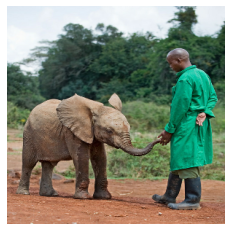

In [37]:
caption_image(img_name_vector_test[1700])

<sos> two people are toilet eating hot in water <eos>


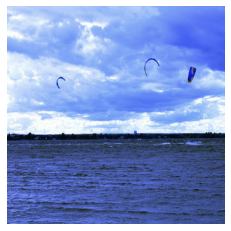

In [23]:
caption_image(img_name_vector_test[9888])

<sos> stop mirror is in building tennis building <eos>


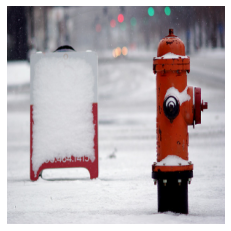

In [24]:
caption_image(img_name_vector_test[129])

<sos> woman is piece down snowy dirt <eos>


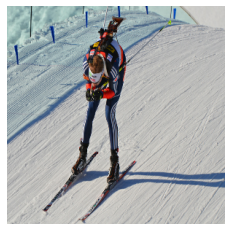

In [25]:
caption_image(img_name_vector_test[600])

<sos> man plate flying down table <eos>


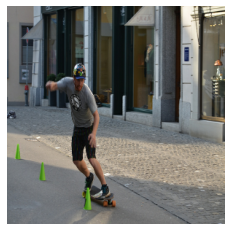

In [26]:
caption_image(img_name_vector_test[2048])

## Sauvegarde du dictionnaire

In [35]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)